# Unsupervised Topic Modelling on Rap Song Lyrics
<i>University of London, DSM020 (October - March 2022) - Assessment II

In my previous coursework submitted as part of the DSM020 assessment, I performed an exploratory data analysis of song lyrics from four different genres. From this analysis, I had discovered that while songs falling under the Pop, Rock, and R&B genres were mainly themed on the topic of love, songs falling under the Rap and Hip Hop genres covered a much wider array of topics. Rap songs were also found to differ from other genres in other aspects, such as sentimentality, length, use of distinct words, and use of slang, dialect, and expletives.

In this project, I will be taking a much more detailed look at the lyrics of Rap (inlcuding Hip Hop) songs. The main objective is to identify the hidden topics within these lyrics, thereby enabling an improved understanding and appreciation of the variablility of this genre. To do this, I will make use of a large online throve of Rap song lyrics, providing data on around thirteen thousand songs in the English language. After a rigorous cleaning of the dataset, a Latent Dirichlet Allocation (LDA) will be used to generate unsupervised topic labels for the lyrics.

The project is structured as follows. The first section outlines the procedure used to scrape the lyrics data from an online source. In the second section, I clean and process the raw data in preparation for its use by the topic modelling algorithm. The third section describes and implements the algorithm, with the fourth section providing analysis of the dataset and the main results. In the final section I outline my main conclusions and other considerations.

<b><i>Note:</b></i> The final dataset was quite large (around 40MB), so along with this notebook I have only provided a small sample of the dataset. Naturally, replicating the below results would require the full dataset - this is available upon request. 

In [1]:
#Importing required libraries

#general
import numpy as np
import csv
import ast
from IPython.display import clear_output
import warnings
import unittest

#webscraping
import requests
from bs4 import BeautifulSoup

#text processing & nlp
import re
import string
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import wordnet 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
 
#visualistion
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn
from wordcloud import WordCloud

#modelling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\darma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\darma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\darma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\darma\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\darma\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence t

In [2]:
#visualisation settings
%matplotlib inline
sns.set_style("darkgrid")
pyLDAvis.enable_notebook()

#the below to prevent warnings thrown when running pyLDAvis
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings('ignore', category=FutureWarning)

## I. Data Collection

Song lyrics data was collected from the Lyrics.com website (https://www.lyrics.com/). Lyrics.com is part of the STANDS4 Network, a digital media provider of free online resources. The site provides a  comprehensive online lyrics database across several genres, partly submitted by users. The <i>robots.txt</i> provided along with the site does not disallow web crawlers.

This data source is different from the one used in my previous project - this change was motivated by the much larger database on Lyrics.com and its regular updates, meaning that even very recent songs will be featured.

The site allows the filtering of songs by genre. As at the date of scraping (31-Jan-2022) there were over 14,000 songs labelled under the 'Hip Hop' genre (on closer inspection, it appears that Rap and Hip Hop songs were all grouped together under this label). The URL for the genre index is https://www.lyrics.com/genre/Hip%20Hop. This genre index, which is paginated into 24 songs per page, lists the songs alphabetically, with each song containing a link to the individual song page. In turn, each individual song page contains important information about the song, including the title, artist, lyrics, and in most cases the year and duration of the song.

In light of this layout, the data scraping will be performed in two steps:
<ul>
   <li>Go through each page in the genre index (596 pages at the time of scraping) and collect the URL of each individual song.</li>
   <li>Loop through the individual song URLs and collect the required information for each song.</li>
</ul>
Scraping will be carried out using Python's requests library to request webpages, and the BeautifulSoup library to extract the required elements.

In [3]:
#setting requests header
request_header = ({'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36',
               'Accept-Language': 'en-GB,en;q=0.9,en-US;q=0.8,mt;q=0.7'     
                })

### I.I Scraping Song URLs

The below are helper functions for scraping the song URLs from the genre index.

The get_number_pages function grabs the number of pages to be scraped - this is equal to the number of the last page in the page navigator at the bottom of the genre index URL (tag 'a', class 'rc5').

The song_url_scraper function loops through each of the pages, starting from the default current_page = 1 until current_page is equal to the output of the get_number_pages function. The title of each song, linked to the individual song page, is housed in a 'p' tag with class 'lyric-meta-title'. The function grabs each of these tags (24 per page) and then from each one grabs the href attribute of the underlying 'a' tag. These URLs are appended to the urls_list variable, which is the output of the function. For each page scraped the function prints a success message, thereby providing the user with runtime feedback.

The song_url_scraper function also includes an error capturing ability. If the page does not load properly (timeout after five seconds) or any other exception is encountered, the function is programmed to retry running on that same page, for a maximum of five times. These retries are tracked by the retry_counter variable. Should a page be retried for five times with no success, the error_message function is called. This throws an error message, asking the user for an input. Should the user decide to continue ('y'), the song_url_scraper function will skip the error page and continue on to the next page. This is useful if the user believes that the error is related to just one particular page. On the other hand, if the user decides to stop ('n'), maybe because there is a larger issue at stake (e.g. network issues) or a number of pages in succession have thrown errors, the song_url_scraper function will return the data scraped so far and break. The user can then resolve the issue and save the outputted data, and later re-start the function from the last page scaped by altering the initial current_page parameter.

In [4]:
def get_number_pages(genre_url):
    '''
    DESCRIPTION:
    Grabs number of pages in a genre index, which is the last page in the index
    PARAMETERS:
    genre_url is the URL of the first page of the genre index
    OUTPUT: 
    Returns number of pages as integer
    '''
    home_html = requests.get(genre_url, headers = request_header)
    home_soup = BeautifulSoup(home_html.content,"html.parser") 
    pages_inactive = home_soup.find_all('a',{'class':'rc5'})
    number_of_pages = pages_inactive[-1].text
    return int(number_of_pages)

def song_url_scraper(genre_url, number_of_pages, current_page=1, retry_counter=0):
    '''
    DESCRIPTION:
    Grab song page URLs from genre index 
    PARAMETERS:
    genre_url is base url of genre index
    number_of_pages is number of pages to scrape
    current_page is the start page - default value of 1; can be changed if one wishes to start scraping from different page
    retry_counter is retry counter for when function throws an error - default value of 0
    OUTPUT:
    List of scraped URLs
    '''   
    urls_list = []
    
    while current_page <= number_of_pages: 
        
        try:
            request_url = genre_url + '/' + str(current_page)

            page_html = requests.get(request_url, headers = request_header, timeout=5)
            soup = BeautifulSoup(page_html.content,"html.parser")

            urls_html = soup.find_all('p',{'class':'lyric-meta-title'}) 

            for elem in urls_html:
                song_url = elem.find('a')['href']
                urls_list.append(song_url)

        #if error thrown
        except Exception as e:
            print(f'Error on page {current_page} - {e}')
            retry_counter += 1
            
            if retry_counter <= 5:
                clear_output()
                print(f'Retry #{retry_counter} for page {current_page}')
                current_page = current_page
                continue 
                
            else: 
                error_message(current_page, number_of_pages)
        
        #if scraping succesful
        else:
            clear_output()
            print(f'Page {current_page} scraped')

            if current_page == number_of_pages:
                print('FINISHED!')
                break
            else:
                retry_counter = 0 #reset counter
                current_page += 1 #continue looping
        
    return urls_list

def error_message(current_page, number_of_pages):
    '''
    DESCRIPTION:
    Ask user what to do in case of error
    PARAMETERS:
    current_page is page currently being scraped
    number_of_pages is number of pages to be scraped 
    OUTPUT:
    Error message asking for user input  
    '''
    ans = input(f'Maximum number of retries exceeded on page {current_page}. Do you wish to continue (y/n)?')
    if ans.lower() == 'y': 
        current_page += 1 #scraper function continues to next page
        retry_counter = 0
    elif ans.lower() == 'n': 
        print(f'Scraping stopped on page {current_page}')
        current_page = number_of_pages + 1 #this will break the while loop but still return function output
    else:
        print('Please insert an appropriate input! (y or n)!') 
        error_message()

Below I perform the actual scraping.

<i>*Note: The below code can take a while to run, so is provided in markdown form. For ease of accessibility, the scraped song URLs have been saved to a .txt file (urls.txt) and are provided along with this notebook.</i>

```
#scraping urls
genre_index_url = f'https://www.lyrics.com/genre/Hip%20Hop' #base genre index url
number_pages = get_number_pages(genre_index_url) #number of pages to be scraped
song_urls = song_url_scraper(genre_index_url, number_pages) #running scraper

#saving links to file
with open('urls.txt', 'a') as file:
    for url in song_urls:
        file.write("https://www.lyrics.com" + "%s\n" % url)
```

### I.II Scraping Song Data

Now I go through each song URL and scrape the song data using the song_info_scraper helper function below. Some unittests are added to the code to ensure correct performance.

The song title is the 'h1' tag, id 'lyric-title-text', while the artist is in the 'h3' tag, class 'lyric-artist'. The lyrics are in the 'pre' tag, id 'lyric-body-text'.

Grabbing the info on the year and the song duration was a bit more complex as these are not available for each song. Thus, the function needed to account for instances where one or both of these elements did not exist. 

The elements, when present, are both found in the 'div' tag with class 'lyric-details'. When the year info exists, this will be preceded by a 'dt' tag with the text 'Year:'. The year info itself will be contained in the next tag, which is a 'dd' tag wth class 'dd-margin'. Hence, the function first checks if the 'dt' tag containing 'Year:' exists; if it does, it calls the next 'dd' tag and grabs the year info; if it doesn't, the function will return 'N/A'.

Similarly the duration info, when present, is always preceded by a clock image (tag 'i', class 'far fa-clock'). If this image exists on a page, the function will call the 'dd' tag (class 'dd-margin') that follows this clock image; if the image is not present, the song has no duration info and hence an 'N/A' is returned.

In [5]:
def song_info_scraper(song_url):
    '''
    DESCRIPTION:
    Scrapes individual song info and lyrics
    PARAMETERS:
    song_url is the song URL from Lyrics.com
    OUTPUT: 
    Returns a tuple containing info on (song title, artist, year, duration, lyrics)
    '''
    song_html = requests.get(song_url, headers = request_header, timeout=5)
    song_soup = BeautifulSoup(song_html.content,"html.parser")

    #title
    song_title = song_soup.find('h1',{'id':'lyric-title-text'}).text

    #artist
    artist = song_soup.find('h3',{'class':'lyric-artist'}).text

    info_div = song_soup.find('div',{'class':'lyric-details'})
    #year
    pattern = 'Year:'
    year_info = info_div.find('dt', text = pattern) 
    if year_info is not None: #checking if year info exists
        year = year_info.find_next('dd',{'class':'dd-margin'}).text
        #info is contained in 'dd' tag following year_info element
    else: 
        year = 'N/A'

    #duration
    clock_image = info_div.find('i',{'class':'far fa-clock'})
    if clock_image is not None: #checking if duration info exists
        length = clock_image.find_next('dd',{'class':'dd-margin'}).text
        #info is contained in 'dd' tag following clock_image element
    else: 
        length = 'N/A'

    #lyrics
    song_lyrics = song_soup.find('pre',{'id':'lyric-body-text'}).text
    
    #make sure that all elements exist (or at least 'N/A', otherwise throw an error)
    for i in [song_title, artist, year, length, song_lyrics]:
        assert i is not None and len(str(i)) != 0, 'Assertion Error, one element is missing!' 

    return song_title, artist, year, length, song_lyrics

#unittesting
class test_scraping(unittest.TestCase):
    '''
    Unit testing for the song_info_scraper function.
    '''

    def setUpClass():
        '''
        This function will run before every other test.
        '''
        global test_soup #allows test_soup to be used in below tests
        test_url = 'https://www.lyrics.com/lyric/5564474/Nelly/%231' #can be changed to any URL
        test_html = requests.get(test_url)
        test_soup = BeautifulSoup(test_html.content,"html.parser")   
             
    def test_response_ok(self):
        '''
        Does website send response?
        '''
        self.assertIsNotNone(test_soup)

    def test_title(self):
        '''
        Check title exists.
        '''
        test_title = test_soup.find('h1',{'id':'lyric-title-text'})
        self.assertIsNotNone(test_title)
        
    def test_lyrics(self):
        '''
        Check lyrics exist.
        '''
        test_lyrics = test_soup.find('pre',{'id':'lyric-body-text'})
        self.assertIsNotNone(test_lyrics)

    def test_lyrics_isstring(self):
        '''
        Check lyrics are strings and not empty.
        '''
        test_lyrics = test_soup.find('pre',{'id':'lyric-body-text'}).text
        self.assertTrue(type(test_lyrics)==str and len(test_lyrics)!=0)

unittest.main(argv=['ignored', '-v'], exit=False)


test_lyrics (__main__.test_scraping)
Check lyrics exist. ... ok
test_lyrics_isstring (__main__.test_scraping)
Check lyrics are strings and not empty. ... ok
test_response_ok (__main__.test_scraping)
Does website send response? ... ok
test_title (__main__.test_scraping)
Check title exists. ... ok

----------------------------------------------------------------------
Ran 4 tests in 1.643s

OK


Now I read the previously scraped URLs from file and loop through them using the song_info_scraper function. The output for each song is stored in the song_data variable. Error capturing is used to capture issues such as page timeouts or NoSuchElement exceptions; in such cases, the code will retry the page up to five times before breaking. When this occurs, the user can restart the scraper by the setting page_counter variable to the last page scraped - this will append the data to the song_data variable on top of previously scraped data (so no previosuly scraped data is lost).

<i>*Note: The below code can take a while to run, so is provided in markdown form. For ease of accessibility, the scraped song data has been saved to a .csv file (scraped_data.csv) and is provided along with this notebook.</i>

```
#reading urls 
with open('urls.txt') as file:
    lines = file.readlines()
    urls_to_scrape = [line.rstrip() for line in lines] #converting to list

#setting initial variables
song_data = []
page_counter = 0
page_retries = 0

#scraping info
while page_counter < len(urls_to_scrape):
    
    try:
        song_url = urls_to_scrape[page_counter]
        song_title, artist, year, length, song_lyrics = song_info_scraper(song_url)
        song_data.append((song_title, artist, year, length, song_lyrics, 'HipHop', song_url))
    
    #if error encountered
    except Exception as e:
        print(f'Error on song {page_counter} - {e}')
        page_retries += 1
        
        if page_retries <= 5:
            clear_output()
            print(f'Retry #{page_retries} for page {page_counter}')
            page_counter = page_counter
            continue 
        else: 
            print(f'Maxmimum number of retries for page {page_counter} exceeded! Closing...')
            break
    
    #if no error encountered
    else:
        clear_output()
        print(f'Page {page_counter} scraped')

        if page_counter == (len(urls_to_scrape) - 1):
            print('FINISHED!')
            break
        else:
            page_retries = 0 
            page_counter += 1 

#saving to file
with open('scraped_data.csv', 'a', encoding='UTF8', newline='\n') as file:
    output = csv.writer(file)
    output.writerow(['Title', 'Artist', 'Year', 'Length', 'Lyrics', 'Genre', 'URL'])
    for row in song_data:
        output.writerow(row)
```

## II. Data Processing

The aim of this section is to clean and prepare the raw data for use in the analysis and modelling sections below. Given the nature of Rap music, which contains a lot of dialect and slang, this section was the hardest and most time-consuming to implement, but also the most necessary.

### II.I Importing & Overview

I first import the scraped data, which is stored in a .csv file. The below code also provides a general overview of the raw dataset.

In [6]:
data_scraped = pd.read_csv('scraped_data.csv', encoding='UTF8') #importing data
print(f'The dataset contains {len(data_scraped)} songs.\n')

data_scraped.head()

The dataset contains 14295 songs.



,Title,Artist,Year,Length,Lyrics,Genre,URL
0,#1,Nelly,2002,03:18,Uh uh uh\nI just gotta bring it to they attent...,HipHop,https://www.lyrics.com//lyric/5564474/Nelly/%231
1,#1,Big Tymers,2002,04:43,\n\nChorus (2x):(Mannie Fresh)\nAll the nigga...,HipHop,https://www.lyrics.com//lyric/26433573/Big+Tym...
2,#1,"Clipse, Nelly, Postaboy",2003,05:07,Uh uh uh\r\nI just gotta bring it to they atte...,HipHop,https://www.lyrics.com//lyric/27233608/Various...
3,#1 Player,Red Hot Lover Tone,1995,04:06,\r\n[Rich Nice]\r\nWhat I want you to underst...,HipHop,https://www.lyrics.com//lyric/2608484/Red+Hot+...
4,#1 Stunna,"Big Tymers, Lil Wayne, Juvenile",2000,04:41,Nigga can't out-stunt me when it come to these...,HipHop,https://www.lyrics.com//lyric/3600097/Various+...


Before proceeding further, I noticed that there were a number of songs in foreign languages. For the purposes of this project, I'd like all songs to be in English, so I use the scrapy library's LanguageDetector to detect the language of each song, and then filer out non-English songs. 

The below code sets up the Language detector, with the function detect_language returning the detected language of a particular song. 

<i>*Note: The below code can take a while to run, so is provided in markdown form. For ease of accessibility, the filtered dataset of English songs, has been saved to a .csv file (scraped_data_langs.csv) and is provided along with this notebook.</i>

```
#setting up spacy language detector
def get_lang_detector(nlp, name):
    return LanguageDetector()
nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

def detect_language(text):
    '''
    DESCRIPTION:
    Returns language of text using spacy's language detector
    REQUIRES:
    Requires prior setting up of spacy 'nlp' pipe language_detector
    PARAMETERS:
    text is text to be passed through language detector
    OUTPUT:
    Returns detected language as string
    '''
    text_processing = nlp(text) #pass text through pipe
    detect_language = text_processing._.language #a dictionary of language and scores
    language = detect_language['language']
    return language

#applying language detector and saving output to .csv
data_scraped['Language'] = data_scraped.apply(lambda x: detect_language(x['Lyrics']), axis=1)
data_scraped.to_csv('scraped_data_langs.csv', index = False)
```

Here is an overview to the language distribution of songs. Over 90% of songs are in English, which means I will only lose just under 10% of the dataset.

In [7]:
data_raw = pd.read_csv('scraped_data_langs.csv', encoding='UTF8')

#calculating percentage of songs per language
lang_prc = data_raw['Language'].value_counts(normalize=True)*100 
lang_prc = pd.DataFrame(lang_prc) #convert to dataframe

#combining small categories into an 'other' category
other = sum(lang_prc['Language'][3:]) #sum of languages to be included in 'other' (excluding top 3)
other = pd.Series({'Language':other}) #converting to series
other.name = 'other' #giving series index label
lang_prc = lang_prc.iloc[0:3,:] #filtering out languages that have been combined
lang_prc = lang_prc.append([other]) #appending 'other' row to dataframe

#styling
lang_prc = lang_prc.style.set_caption("% Songs by Language").format('{:.2f}')

#showing
lang_prc


,Language
en,91.19
fr,3.12
de,2.93
other,2.76


Filtering out foreign songs and an overview of the dataset

In [8]:
data_raw_en = data_raw[data_raw['Language']=='en'].copy()
print(f'The dataset now contains {len(data_raw_en)} English language songs.\n')

The dataset now contains 13036 English language songs.



#### Checking Null Values

As expected, there are some null values in the Year and Length columns. The remaining data columns are fine.

In [9]:
print('NULL VALUES:\n')
print(data_raw_en.isnull().sum())

NULL VALUES:

Title          0
Artist         0
Year         286
Length      1372
Lyrics         0
Genre          0
URL            0
Language       0
dtype: int64


#### Year Data

Converting 'Year' column to numeric and identify year range of songs. It seems like we have songs ranging from the 1950s to 2019. 

I create a column grouping songs into decade bins. There are very little songs pre-1980, so I combine these with 80s songs into one 'pre-1990s' bin.

In [10]:
#convert strings to numeric
data_raw_en["Year"] = pd.to_numeric(data_raw_en["Year"])

#viewing data
print('---Year Outliers---')
#print(f'Unique Year Values: {data_raw_en.Year.unique()}\n')
#print(f'Unique Year Values: {data_raw_en.Year.value_counts()}\n')
print(f'Earliest: {min(data_raw_en.Year.unique())}')
print(f'Latest: {max(data_raw_en.Year.unique())}\n')

#grouping into decade bins
decade_labels = ['pre-90s', '90s', '00s', '10s']
decade_bins = [1949, 1989, 1999, 2011, 2021] #bottom not included but top included
data_raw_en['Decade'] = pd.cut(data_raw_en['Year'], bins=decade_bins, labels=decade_labels)

print('---Decade Counts---:')
data_raw_en['Decade'].value_counts()

---Year Outliers---
Earliest: 1957.0
Latest: 2019.0

---Decade Counts---:


00s        6633
90s        3506
10s        2201
pre-90s     410
Name: Decade, dtype: int64

#### Song Duration Data

The 'Length' column is currently strings of timestamps. I use the get_seconds function below to convert these strings into number of seconds - in this way we can easily do mathematical operations such as max, min, and mean.

There are some outliers in the data, such as very short songs and very long songs. I remove these outliers (songs shorter than 60 seconds and songs longer than 15 minutes).

In [11]:
#get_seconds function
def get_seconds(time):
    '''
    DESCRIPTION:
    Convert string timestamps to seconds
    PARAMETERS:
    time is a stringed timestamp in the form M:S
    OUTPUT
    number of seconds as integer
    '''
    if ':' in str(time):
        parts = str(time).split(':')
        standards = [60,1] #seconds in 1 minute, 1 second
        secs = sum([int(i)*j for i,j in zip(parts, standards)])
    else:
        secs = np.nan #converting missing data to np.nan
    return secs

#applying
data_raw_en['Length_Seconds'] = data_raw_en['Length'].map(get_seconds)

print('---Length Outliers---')
print(f'Maximum Length for song is: {data_raw_en.Length_Seconds.max()}')
print(f'Minimum Length for song is: {data_raw_en.Length_Seconds.min()}\n')

#remove songs shorter than 1 minute (60 secs) and longer than 15 minutes (900 secs)
data_raw_en = data_raw_en.drop(data_raw_en[(data_raw_en.Length_Seconds < 60) | (data_raw_en.Length_Seconds > 900)].index)

---Length Outliers---
Maximum Length for song is: 2682.0
Minimum Length for song is: 1.0



#### Artist Data

A number of songs have multiple artists. It appears that the artist names are split using commas or ampersands. I will convert artist data into a list using the .split() method, with these symbols as the delimeters. This splitting will make it easier to view songs by artist later on.

In [12]:
#viewing outliers
print('---Artist Outliers---')
print(f'Longest Artist title is: {data_raw_en.loc[data_raw_en.Artist.map(len).idxmax()].Artist}')
print(f'Shortest Artist title is: {data_raw_en.loc[data_raw_en.Artist.map(len).idxmin()].Artist}\n')

def artist_split(text):
    '''
    DESCRIPTION:
    Split artist names
    PARAMTERS:
    text is string of artist names
    OUTPIT:
    List of artist names
    '''
    text = re.split(', | & ', text)
    return text

data_raw_en['Artist'] = data_raw_en['Artist'].map(artist_split)

---Artist Outliers---
Longest Artist title is: Caryn Jones, Steve Porcaro, Annette Sanders, Jesse Corti, Geoff Grace, Rodger Bumpass, Brian Jones, Susan Silo, Dawn McMillan, Phillip G. Proctor, Natalia Harris, Maurice La Marche, Jonathon Ungar, Hattie Winston, Tracy Spindler, Brandi Stewart, Gregory Martin, Anna Mathias, Alan Shearman, Emily Bernstein, Michael Jackson, Maxi Anderson, Michael Boddicker, Brad Buxer, Reeve Carney
Shortest Artist title is: X



### II.II Cleaning Lyrics Data

The lyrics data is the most vital piece of information in the datastet, as it will be fed to the LDA to uncover the latent topics hidden in the song lyrics. There are a number of text processing steps which are common to many natural language processing tasks. These include the lower-casing of all text, the removal of punctuation, tokenisation, and lemmatisation.

Other than these, the Rap lyrics need to be cleaned further due to a number of issues. This is mainly due to the use slang in these songs. Slang leads to words being contracted or written in shortened form (even words that are not commonly contracted in the English language), expletives, which in this dataset tend to be partly covered with asterisk (\*) marks, and other incorrectly spelt words.

The below line of code extracts the lyrics data from the dataframe into a list, which should make looping and cleaning easier.

In [13]:
#extracting lyrics data
lyrics = [text.lower() for text in data_raw_en['Lyrics']]

On eyeballing the data, I noticed that there are three versions of the apostrophe used to seperated contracted phrases (',\`,’). In order to make cleaning easier, I used regex to convert these into the same apostrophe mark.

In [14]:
#grouping contraction marks
lyrics = [re.sub(r"[\`\’]", "\'", text) for text in lyrics]

The cleaning process is divided into three stages. In Stage I, I clean the lyrics of common clitic contractions and most punctation marks. Stage II is where I tokenise and lemmatise the words. Stage III is where I identify incorrectly spelled words and slang words, which are either cleaned or tagged as 'unknown'.

#### STAGE I: Clitic Contractions and Punctuation

Unfortunately, the common use of punctuation in slang means that I cannot clean the text of all punctuation in one fell swoop, as this would make it impossible to identify words that have been shortened. Hence, this must be done in a step by step process, using the helper functions below.

<ul>
    <li>The abbvs_period function removes the period from within abbreviations. In this way, abbreviations such as 'U.S.A' all become 'USA', thus enabling the LDA to identify them as the same word.</li>
    <li>The remove_hyphens function removes the hyphens joining phrases and seperates the underlying words. So 'one-on-one' becomes 'one on one', enabling the algorithm to process each word seperately.</li>
    <li>The remove_between_parenthesis function removes any words that appear in between parenthesis. Inspection of the lyrics suggests that these parenthesis mainly contain extra information such as the name of a singer singing a certain part of a song, or to mark the chorus.</li>
    <li>The remove_common_punc function removes punctuation marks from the text that are normally not used in contractions or slang. Importantly, this does not include the apostrophe (') or the asterisk (*), which shall be kept for further examination below.</li>
    <li> The common_contractions function uses regex to seperate phrases that are commonly contracted in the English language. So 'can't' becomes 'can not'; again, the scope is to allow the LDA to process these words seperately.</li>
</ul>

In [15]:
def abbvs_period(text):
    '''
    DESCRIPTION:
    Removes the period (.) from within abbreviations (such as U.S.A) and combines them into one token (USA)
    (though doesn't remove periods not between characters, such as at end of sentence)
    PARAMETERS:
    text is string of text to be processed
    OUTPUT
    Outputs a string of text
    '''
    text = re.sub(r"(?<!\w)([A-Za-z])\.", r"\1", text) #/1 means match the first bracketed term (?<!\w)
    return text

def remove_hyphens(text):
    '''
    DESCRIPTION:
    Removes hyphen joining phrases and replace with white space (e.g. 'one-on-one' becomes 'one on one')
    PARAMETERS:
    text is string of text to be processed
    OUTPUT
    Outputs a string of text
    '''
    text = text.replace('-',' ')
    return text

def remove_parenthesis(text):
    '''
    DESCRIPTION:
    Removes text between parentheses of type (), [], {} 
    PARAMETERS:
    text is string of text to be processed
    OUTPUT
    Outputs a string of text
    '''
    pattern = "[\(\[\{].*?[\)\]\}]" 
    #opening paranthesis, maybe followed by any character, and closing parenthesis.
    #? ensures that regex is not greedy and only deletes text up to the first closing parenthesis
    text = re.sub(pattern, '', text)
    return text

def remove_common_punc(text):
    '''
    DESCRIPTION
    Remove common punctuation marks [,!?\".;:({)}]
    PARAMETERS:
    text is string of text to be processed
    OUTPUT
    Outputs a string of text
    '''
    pattern = "[,!?\"\.;:\(\[\{\)\]\}]" #need to use \ before certain characters not to confuse regex with its special characters
    text = re.sub(pattern, ' ', text)
    return text

def common_contractions(text):
    '''
    DESCRIPTION:
    Seperates phrases commonly contracted in the English language (e.g. 'can't')
    PARAMETERS:
    text is string of text to be processed
    OUTPUT
    Outputs a string of text
    '''
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'s", " is", text) 
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"ain\'t", "is not", text) 
    text = re.sub(r"n\'t", " not", text)
    
    #number of different ways of spelling 'I have' (i'v, i've, iv'e)
    #regex code ensures that substitution only takes place when contraction is at end of word ([\s\.])
    text = re.sub(r"\'ve[\s\.]", " have ", text)
    text = re.sub(r"v\'e[\s\.]", " have ", text)
    text = re.sub(r"\'v[\s\.]", " have ", text)
    
    return text


Applying stage I cleaning:

In [16]:
#combining all stage I functions
def clean_stageI(list_of_strings):
    '''
    PARAMETERS:
    list_of_strings is list of strings
    OUTPUT:
    list of cleaned strings
    '''
    I = [abbvs_period(text) for text in list_of_strings]
    II = [remove_hyphens(text) for text in I]
    III = [remove_parenthesis(text) for text in II]
    IV = [remove_common_punc(text) for text in III]
    V = [common_contractions(text) for text in IV]

    return V

lyrics_clI = clean_stageI(lyrics) 

#### STAGE II: Tokenisation and Lemmatisation

Following the first phase of cleaning, the next step is to tokenise and lemmatise the text. 

The function WStokenise performs tokenisation, preparing the text for being passed into the lemmatisation function below. Note that tokenisation is performed on white space, rather than through nltk's tokenisation function. The reason is that nltk's function tends to seperate words tied by a punctuation mark (so a slang such as 'e'rybody' becomes 'e' and 'rybody') - I do not want this for now as I want to be able to identify slang words using the apostrophe further below. 

The function word_lemmatizer lemmatises the wokens using wordnet's lemmatizer. Lemmatisation is done to convert words into their dictionary form. This is useful because it enables to algorithm to process several versions of the same root as one word (e.g. 'knowing', 'knew', 'know'). Furthermore, I can then compare the dictionary words to a corpus of known English words and identify slangs and other unknown or misspelled words.

In [17]:
def WStokenise(text):
    """
    DESCRIPTION:
    Tokenises string (by white space)
    PARAMETERS:
    text is string of text to be processed
    OUTPUT
    Outputs a list of tokens
    """
    tokens = text.split()
    return tokens

def word_lemmatizer(token_list):
    '''
    DESCRIPTION:
    Lemmatizes tokens
    REQUIRES:
    Requires WordNetLemmatizer object named 'lmt'
    PARAMETERS:
    token_list is a list of tokens 
    OUTPUT
    Outputs a list of lemmatized tokens
    '''

    #we may have elements consisting of just white space from previous cleaning.
    token_list = [token for token in token_list if len(token) >= 1] 
    
    #obtain parts of speech tag (for each word, returns a tuple containing (word, part of speech))
    tags = nltk.pos_tag(token_list)
    
    lemmatized_text = []
    
    #for each word, check the nltk part of speech tag and lemmatize 
    #note that pos for nltk and wordnet lemmatizer are different (e.g. 'J' vs. 'a' for adjective)
    for token, tag in tags:
        if tag.startswith('N'): #noun
            lemmatized_text.append(lmt.lemmatize(token, pos = 'n'))
        elif tag.startswith('V'): #verb
            lemmatized_text.append(lmt.lemmatize(token, pos = 'v'))
        elif tag.startswith('J'): #adjective
            lemmatized_text.append(lmt.lemmatize(token, pos = 'a'))
        elif tag.startswith('R'): #adverb
            lemmatized_text.append(lmt.lemmatize(token, pos = 'r'))
        else:          
            lemmatized_text.append(token)
      
    return lemmatized_text


lmt = WordNetLemmatizer()

Applying stage II cleaning

In [18]:
lmt = WordNetLemmatizer() #setting up wordnet lemmatizer

#applying functions
wstokens = [WStokenise(text) for text in lyrics_clI]
wstokens_lem = [word_lemmatizer(token_list) for token_list in wstokens]

#### STAGE III: Identifying Unknowns

Now that words have been tokenised and converted to dicitonary form, I can start identifying unknown words by comparing them to an existing corpus. 

For this purpose, I am using the combination of two corpora, nltk's word corpus and the wordnet corpus. These are combined into an english_vocab variable to give a total of over 320k known words.


In [19]:
#combining nltk and wordnet corpora
nltk_corp = [word.lower() for word in nltk.corpus.words.words()] 
wordnet_corp = [word.lower() for word in wordnet.words()] 
english_vocab = set(nltk_corp + wordnet_corp)
print(f'English vocabulary corpus consists of {len(english_vocab)} words.')

English vocabulary corpus consists of 323592 words.


I now want to compare the lyrics dataset with this english vocabulary. The below function unknown_words does just this.

Remember that we have not yet removed the apostrophe mark from the dataset - in some cases, I realised that some words had this mark not because they were contracted, but because the apostrophe was used as a quotation mark. In order to prevent known words with quotation marks from falling into the unknowns list, the function includes a quick check whereby words beginning or ending with apostrophes are temporarily cleaned of the mark and then compared with the english vocabulary.


In [20]:
def unknown_words(dataset, vocab):
    '''
    DESCRIPTION:
    Compares dataset to an existing vocabulary and lists unrecognised words
    PARAMETERS:
    dataset is a string of words in the dataset
    vocab is the vocabulary being compared to
    RETURNS
    list of words in dataset not in vocab
    '''
    unrecognised = set(dataset) - set(english_vocab)
    
    unknowns = []
    for token in unrecognised:
        if token.startswith('\'') or token.endswith('\''):
            token_test = re.sub('[\']', '', token)
            token_testlem = lmt.lemmatize(token_test) #lemmatise the cleaned word 
            if token_testlem not in english_vocab:
                unknowns.append(token)
        else: 
            unknowns.append(token)
    
    return set(unknowns)

Applying function

In [21]:
#use list comprehension to combine all tokens in the dataset into one string
dataset_corpus = [token for sublist in wstokens_lem for token in sublist]
#get list of unkowns
unknowns = unknown_words(dataset_corpus, english_vocab)
print(f'There are {len(unknowns)} unknown word types in the dataset (out of {len(set(dataset_corpus))}).')


There are 38398 unknown word types in the dataset (out of 64325).


Over half of unknown words are unknown, which is not ideal (though expected given that most slang is still uncleaned). However, what is more important is the frequency of these unknowns compared to known words. While it is impossible to clean all these unknown words, I will try and identify and clean those unknown words that have a high frequency, while removing the rest so that they will not interfere with the algorithm. The treshold frequency for cleaning will be around 150 instances.

The unknown_frequency function returns a dictionary of how many times each unknown word appears in the corpus.


In [22]:
def unknown_frequency(dataset, unknowns):
    '''
    DESCRIPTION:
    Count instances of each word in unknowns in the dataset
    PARAMETERS:
    dataset is a string of words in the dataset
    unknowns is list of unknown words
    RETURNS
    dictionary of unknown words and counts
    '''
    #counting each instances of each unknown    
    unknown_counts = {}
    for token in unknowns:
        count = dataset.count(token)
        unknown_counts[token] = count
        
    #sorted values in descending order
    counts_sorted = {k: v for k, v in sorted(unknown_counts.items(), key=lambda item: item[1], reverse = True)}
       
    return counts_sorted

Applying function: 

<i>*Note: The below code can take a while to run, so is provided in markdown form. The output was necessary to me for to establish the cleaning process done below, but is not necessary for the final output of this project.</i>

```
unknown_counts = unknown_frequency(dataset_corpus, unknowns)

#summing up unknown frequencies
unknown_instances = sum(unknown_counts.values())
print(f'The frequency of unknown words is {unknown_instances} (out of {len(dataset_corpus)})')

#counting estimated number of instances to be clean and % of words in dataset lost 
unknowns_to_clean = 0
instances_to_clean = 0
for k,v in unknown_counts.items():
    if v >= 150:
        unknowns_to_clean += 1
        instances_to_clean += v

print(f'If unknowns with frequencies of over 150 are cleaned, we will be saving {unknowns_to_clean} distinct words, comprising {instances_to_clean} instances.\n')

instances_to_remove = unknown_instances - instances_to_clean
pc_lost_words = round((instances_to_remove/len(dataset_corpus))*100,2)
print(f'This will leave {instances_to_remove} unknown instances to be removed, losing just {pc_lost_words}% of the total dataset')

```


After identifying the most common unknown words, the below code performs the necessary cleaning:

<ul>
    <li>A large number of unknown instances are gerunds (-ing) words that have been shortened. The most common were gerunds with the end 'g' removed (e.g. 'knowin' instead of 'knowing), gerunds with the end 'g' replaced by an apostrophe (e.g. 'knowin'' instead of 'knowing), and gerunds with the -ing substituted with an ''n' (e.g. 'know'n' instead of 'knowing). The function gerund_contractions cleans these instances.</li>
    <li>A number of words have been shortened or covered using punctuation - I manually try to clean these common words using the slang_contractions function, which also makes use of the dictionary d_slang_contractions.</li>
    <li>Now that we have cleaned all necessary slang and contractions, the only_alpha function removes any remaining punctuation and words with non-alpha characters (digits).</li>
    <li>The function misc_cleaning does some more manual cleaning of words by calling on the dictionary d_misc_cleaning - these include words that are commonly misspelled in the text, words that have been shortened, or uncommon words that were not recognized by the wordnet corpus and hence not lemmatized (in this case I simply lemmatised the words by hand and added them to the english vocabulary in the vocab_append list). These words were often names of singers or brand names - it appears that rappers love to name-drop in their lyrics!</li>
    <li>I also remove words with two characters or less as these clutter the dataset and provide little meaning. This is done using the function remove_shorts.


In [23]:
def gerund_contractions(token_list):
    '''
    DESCRIPTION:
    Cleans gerund contractions (-ing words)
    PARAMETERS:
    token_list is a list of tokens
    OUTPUT:
    Returns cleaned list of tokens
    '''
    clean_list = []
    exceptions = (['cousin', 'skin', 'begin', 'within', 'twin', 'shin', 'spin', 'grin', 'thin', 
                   'chin','again', 'akin'])
    for token in token_list:
        
        #words ending in -in preceded by a vowel and longer than 3 letters            
        if re.search('[b-df-hj-np-tv-z]in$', token) and len(token) > 3 and token not in exceptions:
            clean_token = re.sub(r"in$", "ing", token) 
            
        #words ending in 'n or 'in
        elif re.search(r"\w*\'i?n\b", token):
            clean_token = re.sub(r"\'i?n", "", token) #i is optional ('in)
        
        #words ending in -in'   
        elif re.search(r"[a-z]in\'+", token): #sometimes they have more than one apostrophe
            clean_token = re.sub(r"in\'+", "ing", token) 
            
        else: 
            clean_token = token
        
        clean_list.append(clean_token)
            
    return clean_list

def slang_contractions(token_list):
    '''
    DESCRIPTION:
    Cleans slang words shortened by punctuation
    PARAMETERS:
    token_list is a list of tokens
    OUTPUT:
    Returns cleaned list of tokens
    '''
    clean_list = []
    for token in token_list:
        
        #use cleaning dictionary
        if token in d_slang_contractions.keys():
            clean_token = d_slang_contractions[token]
            
        #if 'n' is between two words, then it is and (e.g. rock'n'roll)
        elif re.search('[a-zA-Z]\'n\'[a-zA-Z]', token): 
            clean_token = re.sub(r"\'n\'", " and ", token) 
            
        elif token in ["\'cause", "cause"]:
            clean_token = 'because'

        elif token in ['\'bout', 'bout']:
            clean_token = 'about'

        elif token in ['n*gga', 'n*ggas', 'n****s','n****']:
            clean_token = 'nigger'  

        #contractions of 'every' words (e.g. 'e'rybody')
        elif token.startswith('e') and token.endswith('ry'):
            clean_token = 'every'

        elif token.startswith('e') and token.endswith('thing'):
            clean_token = 'everything'

        elif token.startswith('e') and token.endswith('body'):
            clean_token = 'everybody'

        elif token.startswith('e') and token.endswith('time'):
            clean_token = 'every time'

        elif token.startswith('e') and token.endswith('where'):
            clean_token = 'everywhere'

        elif token.startswith('e') and token.endswith('one'):
            clean_token = 'everyone'

        else: clean_token = token

        clean_list.append(clean_token)
                       
    return clean_list


def only_alpha(token_list):
    '''
    DESCRIPTION
    Cleans any remaining punctuation and removes words containing digits.
    PARAMETERS:
    token_list is a list of tokens
    OUTPUT:
    Returns cleaned list of tokens
    '''
    alpha_list = []
    for token in token_list:
        token_xpunc = token.translate(str.maketrans('', '', string.punctuation))
        if token_xpunc.isalpha() == False:
            continue
        else:
            alpha_list.append(token_xpunc)
    return alpha_list


def misc_cleaning(token_list):
    '''
    DESCRIPTION:
    Miscellaneaous token cleaning
    PARAMETERS:
    token_list is a list of tokens
    OUTPUT:
    Returns cleaned list of tokens
    '''
    clean_list = []
    for token in token_list:

        #use cleaning dicitonary
        if token in d_misc_cleaning.keys():
            clean_token = d_misc_cleaning[token]

        else: clean_token = token

        clean_list.append(clean_token)
                       
    return clean_list

def remove_shorts(token_list):
    '''
    DESCRIPTION:
    Removes words of two or less characters
    PARAMETERS:
    token_list is a list of tokens
    OUTPUT:
    Returns cleaned list of tokens
    '''
    token_list = [token for token in token_list if len(token) > 2]
    return token_list


In [24]:
#dictionary used by slang_contractions function
d_slang_contractions = ({
    'lil\'':'little',
    'sh*t':'shit',
    's***':'shit',
    'd*ck':'dick',
    'f*ck':'fuck',
    'f***':'fuck',
    '\'n\'':'and',
    'y\'all': 'you all',
    'why\'all': 'why are you all',
    '&':'and',
    'b****':'bitch'
})

#dictionary used by misc_cleaning function
d_misc_cleaning = ({
    'ballers': 'baller', #US slang for player
    'glocks': 'glock', #type of gun
    'eazy': 'easy',
    'krazy': 'crazy',
    'hating': 'hate',
    'imma': 'i am going to',
    'mothafucking': 'motherfuck',
    'whatchu': 'what you',
    'girls': 'girl',
    'mics': 'mic', #short for microphone
    'dem': 'them',
    'inna': 'in',
    'hella': 'very',
    'repping': 'rep',
    'sipping': 'sip',
    'luv': 'love',
    'baddest': 'worst',
    'muthafucka': 'motherfucker',
    'philly': 'philadelphia',
    'yup': 'yes',
    'im': 'i am',
    'blunts': 'blunt', #cigar
    'aight': 'alright',
    'finna': 'going to',
    'shoulda': 'should have',
    'thugging': 'thug',
    'thugs':'thug',
    'dr': 'doctor',
    'bro': 'brother',
    'muthafucking': 'motherfuck',
    'others': 'other',
    'boyz': 'boy',
    'balling': 'getting rich', 
    'thangs': 'thing',
    'thang': 'thing',
    'dawg': 'dude',
    'dawgs':'dude',
    'lemme': 'let me',
    'whatcha': 'what you',
    'gots': 'got',
    'def': 'definitely', 
    'cuz': 'because', 
    'doin': 'doing',
    'boys': 'boy',
    'goin': 'going',
    'homies': 'homie', 
    'lil': 'little',
    'gimme': 'give me',
    'outta': 'out of',
    'shorty': 'shawty', #term of endearment
    'tryna': 'trying to',
    'dem': 'them',
    'motherfucking': 'motherfuck',
    'u': 'you',
    'ya': 'you',
    'gonna': 'going to',
    'wanna': 'want to',
    'gotta': 'got to',
    'lotta': 'lot of',
    'ta':'to',
    'babe':'baby',
    'nigga':'nigger',
    'niggas':'nigger',
    'niggaz':'nigger',
    'ol':'old',
    'nuff':'enough',
    'hol':'hole',
    'jus':'just',
    'nuthing': 'nothing',
    'bein': 'being',
    'playas': 'player',
    'coulda': 'could have',
    'woulda': 'would have',
    'muthafuckas': 'motherfucker',
    'sucka': 'sucker',
    'witcha': 'with you',
    'anytime': 'any time',
    'getcha': 'get you',
    'friends': 'friend',
    'brotha': 'brother',
    'sumthing': 'something',
    'suckas': 'sucker',
    'wifey': 'wife',
    'girlies': 'girl',
    'thru': 'through',
    'diamonds': 'diamond',
    'thugged': 'thug',
    'motherfucka': 'motherfucker',
    'hustla': 'hustler',
    'freek': 'freak',
    'mutha': 'mother',
    'shorties': 'shawty',
    'yall': 'you all',
    'tru': 'through',
    'mothafucka': 'motherfucker',
    'sorta': 'sort of',
    'fellas': 'fellow',
    'wassup': 'what is up',
    'whassup': 'what is up',
    'dammit': 'damn it',
    'gotcha:': 'got you',
    'oughta ': 'ought to',
    'motha':'mother',
    'witchu':'with you',
    'brothas': 'brother',
    'everythang': 'everything',
    'mothafuckas': 'motherfucker',
    'dollas': 'dollar',
    'wantcha': 'want you',
    'sweeter': 'sweet',
    'bros': 'brother',
    'shes': 'she is',
    'gangstas': 'gangster',
    'gangsta':'gangster',
    'biatch': 'bitch',
    'thighs': 'thigh',
    'gimmie': 'give me',
    'somthing': 'something',
    'cadillacs':'cadillac',
    'bentleys':'bentley',
    'goodnight': 'good night',
    'texting':'text',
    'motherfuckas': 'motherfucker',
    'muhfuckers': 'motherfucker',
    'muthafucker': 'motherfucker',
    'hennessy': 'hennessey',
    'em':'them'
})
            
#words to append to vocabulary
vocab_append = (['busta', 'gucci', 'shawty', 'dogg', 'kush', 'weezy', 'glock', 'biggie', 'licky', 
                 'phat', 'kane', 'benz', 'mic', 'southside', 'homie', 'bentley', 'cadillac', 'dro',
                'motherfuck','porsche','gotti',  'motherfucker', 'sucker', 'chanel', 'ferrari', 
                 'diamond','prada','grammy', 'hennessey', 'mega', 'timbaland', 'bugatti', 
                 'harley', 'tupac', 'royce', 'eminem', 'barbie', 'bacardi', 'lamborghini', 
                 'dancefloor', 'adidas', 'angeles', 'santana', 'chevrolet', 'jacuzzi', 'ludacris',
                 'instagram', 'vuitton', 'swole', 'swell', 'deuce', 'beyonce', 'dancehall', 
                 'rockstar', 'hottie', 'armani', 'shakira', 'heineken', 'corleone', 'britney', 
                 'reebok', 'rolex'])


Applying stage III cleaning

In [25]:
#appending new words to vocabulary
english_vocab.update(vocab_append)

#combining functions
def clean_stageIII(list_of_lists):
    '''
    PARAMETERS:
    list_of_lists is list of token lists
    OUTPUT:
    List of cleaned token lists
    '''
    I = [gerund_contractions(token_list) for token_list in list_of_lists]
    II = [slang_contractions(token_list) for token_list in I]
    III = [only_alpha(token_list) for token_list in II]
    IV = [misc_cleaning(token_list) for token_list in III]
    V = [remove_shorts(token_list) for token_list in IV]

    return V

#applying
lyrics_clIII = clean_stageIII(wstokens_lem) 

#### Final Stage: Preparing Lyrics for LDA

Now that the lyrics have been thoroughly cleaned, all that remains is to run nltk's tokeniser and lemmatizer on the data using function final_cleaning (just to make sure that everything is in order), and to tag all remaining unknown words as 'UNK' using function map_unknowns.

Cleaned data is then saved to .csv file.

In [26]:
def final_cleaning(token_list):
    '''
    DESCRIPTION
    Tokenise and lemmatise words in preparing for LDA algorithm using nltk and wordnet
    PARAMETERS:
    token_list is a list of tokens
    OUTPUT:
    Returns cleaned list of tokens
    
    '''
    text = ' '.join(token_list)
    nltk_tokens = word_tokenize(text)
    song_lemmas = word_lemmatizer(nltk_tokens)
    return song_lemmas

def map_unknowns(token_list, mapping_dict):
    '''
    DESCRIPTION
    Translates words according to mapping in given dictionary.
    PARAMETERS
    token_list is a list of tokens
    mapping_dict is translation dictionary
    OUTPUT
    List of translated tokens
    '''
    trans = [mapping_dict.get(token,token) for token in token_list]
    #mapping_dict.get(key, default)
    #key is word key to get from mapping dict
    #default is value to return if word not in mapping dict (i.e. if word is not in unkown)
    
    return trans

In [27]:
#applying final_cleaning function
lyrics_cleaned = [final_cleaning(token_list) for token_list in lyrics_clIII]

#new list of unknown words (post-cleaning)
dataset_corpus_v2 = [token for sublist in wstokens_lem for token in sublist] #full corpus string
unknowns_v2 = unknown_words(dataset_corpus_v2, english_vocab)

#tagging unknown words as 'UNK'
unk_mapping = {}
for word in unknowns_v2:
    unk_mapping[word] = 'UNK'   
#applying
lyrics_mapped = [map_unknowns(token_list, unk_mapping) for token_list in lyrics_cleaned]


### II.III Miscellaneous Processing

Some miscellanous processing on other song information. 

Calculating lyric length:

In [28]:
#calculating lyric length
lyrics_length = [len(lyric) for lyric in lyrics_mapped] #approximation as some choruses may be grouped
lyrics_distinct = [len(set(lyric)) for lyric in lyrics_mapped] #approximation due to unknowns

#adding to dataframe
data_raw_en['Lyrics_Cleaned'] = lyrics_mapped
data_raw_en['Lyric_Length'] = lyrics_length
data_raw_en['Distinct_Words'] = lyrics_distinct


Identifying and removing outliers (songs with less than 50 lyrics or less than 25 distinct words). There are no impossibly long lyrics.

In [29]:
# #checking for outliers
# print(f'Maximum Length for song is: {data_raw_en.Lyric_Length.max()}')
# print(f'Minimum Length for song is: {data_raw_en.Lyric_Length.min()}\n')

#dropping outliers
lyrics_outliers = data_raw_en[data_raw_en["Lyric_Length"] < 50].Title.count()
distinct_outliers = data_raw_en[data_raw_en["Distinct_Words"] < 25].Title.count()
print(f'{lyrics_outliers +distinct_outliers} songs will be dropped')

data_raw_en = data_raw_en.drop(data_raw_en[(data_raw_en.Lyric_Length < 50)|(data_raw_en.Distinct_Words < 25)].index)


130 songs will be dropped


Calculating sentiment score for lyrics:

In [30]:
#defining function
def sentiment_analysis(token_list):
    '''
    DESCRIPTION
    Calculates VADER sentiment score.
    PARAMETERS
    token_list is a list of tokens
    REQUIRES:
    SentimentIntensityAnalyzer() object from 'vaderSentiment' library, stored as 'sent_analyser'
    OUTPUT
    Compound sentiment score
    '''
    text = ' '.join(token for token in token_list) #sentiment analyser requires a string of tokens
    score = sent_analyser.polarity_scores(text)['compound'] #obtaining compound score from results dictionary
    return score

#applying
sent_analyser = SentimentIntensityAnalyzer()
data_raw_en['Sentiment_Score'] = data_raw_en['Lyrics_Cleaned'].apply(sentiment_analysis) 

In [31]:
#saving to .csv
data_raw_en.to_csv('data_cleaned.csv', index=False) #index = False stops pandas creating index column when outputting to csv

## III. Methodology and Implementation

The section describes and implements the algorithm to be used to classify the unlabelled song lyrics into different topics. Topic modelling is a statistical unsupervised method used in natural language processing for the classification of documents. It is the process of discovering hidden semantic structures in a text body that go beyond simple word sequences. 

Intuitively, one would expect particular words to appear more or less frequently given a document subject. A topic model captures this intuition in a mathematical framework, which allows examining a set of documents and discovering, based on the statistics of the words in each, what the topics might be and what each document's balance of topics is. The "topics" produced by topic modelling techniques are clusters of similar words.

There are many different topic modelling algorithms, though for the purposes of this project I will be using the Latent Dirichlet Allocation (LDA) algorithm from sklearn. LDA is a topic modelling algorithm that aims to find topics ‘latent’ in the text, assuming that the distribution of topics in a document and the distribution of words in topics are both Dirichlet distributions. LDA assumes that documents are composed of a bag of words that help determine the topics, and maps documents to a list of topics by assigning each word in the document to different topics. Thus, the order of the words and the grammatical role of the words are not considered in this model. In an LDA, each document is simply a mix of topics, and each topic is a mix of words. LDA models are thus similar to Principal Component Analysis in that it decomposes the corpus-document-word matrix into two smaller parts - the document-topic matrix and the topic-word matrix. 

The LDA begins with random assignment of <i>n</i> topics to each word and iteratively improves the assignment of topics to words. The number of expected topics in the corpus <i>n</i> is arbitrary.



### III.I Setting Up

In [32]:
#import cleaned data
data_lda = pd.read_csv('data_cleaned.csv', encoding='UTF8')

An LDA takes as an input a bag of words matrix, hence only raw word counts are required. A bag of words matrix can be easily created using sklearn's CountVectorizer. 

The stop_words parameter is used to remove common stop words in the English language - here, I make use of wordnet's stopwords list with a few additions to account for the 'UNK' tag (hence eliminating all unknown words from the dataset), and other common words such as 'chorus'. The features used are those that have a maximum document frequency of 80% of all documents, and a minimum frequency of 1% of all documents.

After setting up the CountVectorizer as vectorizer, the cleaned lyrics data is passed in to create a bag of words matrix bow_matrix.


In [33]:
#extracting lyrics data from df and converting to list (since pandas reads the list as a string)
lyrics_final = data_lda['Lyrics_Cleaned']
lyrics_final = [ast.literal_eval(lst) for lst in lyrics_final] #converting to list
#joining cleaned tokens into strings (this is what the sklearn's CountVectorizer requires as input)
lyrics_lda = [' '.join(songs) for songs in lyrics_final]

#compliling stopwords
stops = set(stopwords.words('english'))
stops.update(['UNK','chorus']) 

#setting up bag of words matrix
vectorizer = CountVectorizer(max_df=0.80, min_df=0.01, analyzer='word', stop_words=stops)  
bow_matrix = vectorizer.fit_transform(lyrics_lda)

features = vectorizer.get_feature_names()
print(f'Number of features to be inputted to model: {len(features)}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['unk'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Number of features to be inputted to model: 1886


### III.II Implementing

The LDA algorithm is dependent on a number of hyperparameters. These include the number of topics (n_components), the learning decay (learning_decay), the learning offset, and the maximum number of iterations (max_iter). Apart from these, there are also the hyperparameters used in defining the bag of words matrix, including the number of features to use (determined by min_df and max_df). 

The following hyperparameters were chosen judgementally, with the remainder being tested using cross validation grid search to determine their optimal values:

<ul>
    <li>max_iter determines the maximum number of passes over the training data. I use sklearn's default of 10 for the final model, though for computational puposes I reduce this to 5 during the grid search.</li>
    <li>max_df and min_df determine the number of features to be included in the bag of words matrix and to be used by the algorithm. As seen above, I decided that a reasonable range would be to include features that appear in over 1.0% of songs and exclude those appearing in over 80% of songs. This provides around 1,800 features.</li>
    <li>The random state ensures that results are reproducable every time the code is run.</li>
</ul>

For the remainder (number of topics, learning_decay, and learning offset), I used sklearn's GridSearchCV to find their optimal values. For the number of topics, I decided that a range of between 4-12 topics was reasonable to capture the topic diversity of the songs, while at the same time maintaining a number of topics low enough to ensure interpretability. The learning decay controls the learning rate, and according to sklearn documentation should be set between 0.5 and 1.0 to guarantee asymptotic convergence; I decide to test values of 0.5, 0.7, and 0.9. The learning offset is a parameter that downweights early iterations in online learning, and should be greater than 1. I test values of 10, 30, and 50.

The below markdown code performs the grid search cross validation. This search is done using the score function provide by the estimator, which in the case of the LDA is the log likelihood.

```
#hyperparameters to test
test_params = {'n_components': [4, 5, 6, 7, 8, 9, 10, 11, 12], 'learning_decay': [.5, .7, .9], 'learning_offset': [10, 30, 50]}

#initialise model and grid search, and fit
lda = LatentDirichletAllocation(max_iter=5, learning_method='online',random_state=0)
lda_test = GridSearchCV(lda, param_grid=test_params)
lda_test.fit(bow_matrix)

#best model from grid search
best_lda = lda_test.best_estimator_
print("Best Model's Params: ", lda_test.best_params_)
```

The optimal hyperparamters were found to be 4 topics, with a learning decay of 0.7 and a learning offset of 10.

I now run the LDA model using the optimal paramters, but using 10 maximum iterations.

In [34]:
#running algorithm
lda = LatentDirichletAllocation(n_components=4, max_iter=10, learning_method='online', learning_offset=10, learning_decay=0.7, random_state=0).fit(bow_matrix)

The model can be evaluated using the perplexity score; i.e how ‘surprised’ the algorithm is to see a term within a given topic. A low value indicates a better model.

In [35]:
#evaluating
print("Perplexity: ", lda.perplexity(bow_matrix))

Perplexity:  656.6712002924171


## IV. Results

### IV.I Visualising Results

I use pyLDAvis to visualise the results of the LDA, which provides interactive visualisation of the output. pyLDAvis was developed by Sievert & Shirley (2014).

This visual is based on the word relevance measure. This denotes the degree to which a term appears in a particular topic to the exclusion of others. Relevance is a weighted average of two terms, with λ controlling the weighting. When λ = 1, the relevance is defined entirely by the probability of a word within the topic (i.e. most common words per topic). When λ = 0, relevance is based entirely on a word's lift, which measures the probability of term given a topic out of its total probability in the corpus (i.e. words that are most specific to the topic). According to Sievert & Shirley, the optimal value for λ to aid topic interpretation is 0.6.

On the below visual, the LHS displays each topic as a bubble in a 2D-space using multi-dimensional scaling. The bubble size is indicative of topic frequency within the corpus. Distance between the topics is an approximation of semantic relationship between the topics, with topics sharing common words closer in distance. The RHS shows the frequency distribution of the words in the documents (blue) and the frequency of each word (red) for the topic under view. Hovering over each word gives an idea of which topics the word appears in. One can scroll through topics using the menu bar on the top left. In the top right menu, one can adjust the λ weighting, which determines whether the show the most common words in a topic (λ = 1) or the most specific words (λ = 0).

In [36]:
#generating
visual = pyLDAvis.sklearn.prepare(lda, bow_matrix, vectorizer, mds='tsne', sort_topics=False) 
#sort_topics=False keeps the same topic ordering as sklearn

#viewing
pyLDAvis.display(visual)

The pyLDAvis object provides a number of attributes which we can use for further analysis, most particularly topic_info. topic_info returns a dataframe of terms, including their log probability and log lift and their category (topic). Log probability and log lift are used in the relevance measure proposed by Sievert & Shirley (2014), with λ determining the weight of each in the measure. We can use this information to grab the top words per topic. To aid topic interpretation, I shall grab both the most specific words per topic (λ = 0) and the most common words (λ = 1).

In [37]:
def get_common_words(visual, n_words):
    '''
    DESCRIPTION:
    Get most common words per topic (lambda = 1)
    PARAMETERS
    visual is pyLDAvis output for LDA model
    n_words is number of top words to show
    OUTPUT:
    Dictionary of most common words by topic
    '''
    n_topics = len(visual.topic_order) #.topic_order attribute gives list of topics
    lmbda = 1
    common_words = {}
    
    for i in range(1,n_topics+1): 
        info = visual.topic_info
        topic = info[info.Category == 'Topic'+str(i)].copy() #filtering topic_info dataframe by topic
        topic['relevance-prob'] = topic['loglift']*(1-lmbda)+topic['logprob']*lmbda #measuring relevance with lambda = 1
        common_words['Topic '+str(i)] = topic.sort_values(by='relevance-prob', ascending=False).Term[:n_words].values #adding to dict and sorting
        
    return common_words

def get_specific_words(visual, n_words):
    '''
    DESCRIPTION:
    Get most specific words per topic (lambda = 0)
    PARAMETERS
    visual is pyLDAvis output for LDA model
    n_words is number of top words to show
    OUTPUT:
    Dictionary of most specific words by topic
    '''
    n_topics = len(visual.topic_order) 
    lmbda = 0
    specific_words = {}
    
    for i in range(1,n_topics+1): 
        info = visual.topic_info
        topic = info[info.Category == 'Topic'+str(i)].copy() 
        topic['relevance-prob'] = topic['loglift']*(1-lmbda)+topic['logprob']*lmbda #measuring relevance with lambda = 0
        specific_words['Topic '+str(i)] = topic.sort_values(by='relevance-prob', ascending=False).Term[:n_words].values
        
    return specific_words

#applying
common_words_by_topic = get_common_words(visual, n_words=15)
specific_words_by_topic = get_specific_words(visual, n_words=15)


#displaying
def show_relevant_words(common_words, specific_words, topic):
    '''
    DESCRIPTION:
    Neatly printing output of get_common_words and get_specific_words functions
    PARAMETERS
    common_words, specific_words are dictionary output of get_common_words and get_specific_words functions
    topic is topic output to print
    OUTPUT:
    Print display
    '''
    print(topic.upper(),':\n')
    print('Most Common Words:', common_words[topic], '\n')
    print('Most Specific Words:', specific_words[topic], '\n')
    print('---------\n')
    
topics = common_words_by_topic.keys() #get list of topic headings
print('MAIN RESULTS:\n---------\n')
for t in topics:
    show_relevant_words(common_words_by_topic, specific_words_by_topic, t)

MAIN RESULTS:
---------

TOPIC 1 :

Most Common Words: ['love' 'want' 'baby' 'girl' 'say' 'make' 'let' 'feel' 'yeah' 'need'
 'tell' 'see' 'time' 'think' 'one'] 

Most Specific Words: ['darling' 'loving' 'relationship' 'lonely' 'love' 'ooh' 'anymore'
 'beautiful' 'lately' 'lover' 'fantasy' 'whoa' 'baby' 'goodbye' 'someone'] 

---------

TOPIC 2 :

Most Common Words: ['one' 'make' 'time' 'say' 'life' 'come' 'man' 'never' 'live' 'see' 'take'
 'try' 'day' 'think' 'back'] 

Most Specific Words: ['freedom' 'human' 'destroy' 'youth' 'wisdom' 'glory' 'sword' 'knowledge'
 'birth' 'defeat' 'fate' 'reign' 'criminal' 'sentence' 'wise'] 

---------

TOPIC 3 :

Most Common Words: ['nigger' 'fuck' 'shit' 'bitch' 'money' 'want' 'yeah' 'see' 'back' 'hoe'
 'make' 'hit' 'come' 'real' 'put'] 

Most Specific Words: ['bitch' 'motherfuck' 'nigger' 'dogg' 'gotti' 'motherfucker' 'chronic'
 'pussy' 'chopper' 'snoop' 'westside' 'hoe' 'fuck' 'clique' 'kush'] 

---------

TOPIC 4 :

Most Common Words: ['let' 'come

### IV.II Topic Interpretation

Looking at the display above, we can see that there is clearly some level of distinction between the four topics.


Topic 1 is clearly the topic of love. Almost every word in both the most common and the most specific lists for this topic are love related - words such as 
'love', 'baby', 'darling', and 'relationship', and verbs such as 'want' and 'need'. There is also a lot of emotion - specific keywords include 'lonely', 'cry', and 'joy'. Hence, I will label this topic 'Emotional'.

Topic 2 has a philosophical vibe to it. Looking at the specific words for this topic, we find words such as 'freedom', 'knowledge', 'youth', 'wisdom', 'birth', and 'defeat'. Common words include 'life', 'man', and 'think'. Hence, I will label this topic as 'Philosphical'. 

Topic 3 contains lots of expletives and violence-related keywords, which some rap artists are famous for. Indeed, rap artists are known for being outspoken about the issues being faced in poor, urban neighbourhoods. Common words include 'nigger', 'fuck', 'shit', 'bitch', 'hit', and 'hoe', with specific keywords including 'motherfucker', 'gotti', and 'clique'. There is also a materialistic element, with keywords such as 'money'. I shall label this topic 'Issues/Crime'.

Topic 4 clearly has a party vibe to it. Words like 'rock', 'girl', 'move', and 'roll' are very common to this topic, and specific words are laden with party and sexual references such as 'booty', 'party', 'dance', 'shake', and 'thong'. Hence, I will label this topic as 'Party'.

Now that the topics have been labelled and interpreted, we can perform a more in-depth analysis of topic distribution using the other information present in the dataset, such as by artist. First, I associate each song with a topic. The .transform() method in sklearn's LDA returns a vector for each song with the probability of appearing in each topic. The topic label for each song is the topic with the maximum probability.

In [38]:
#get probabilities by topic
lda_output = lda.transform(bow_matrix) 
topic_labels = ['Emotional','Philosophical','Issues/Crime','Party'] #columns
songs_by_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_labels) #convert to dataframe

#get dominant topic for each song
dominant_topic_index = np.argmax(songs_by_topic.values, axis=1) #returns array of index value of column with largest probability per song
dominant_topic_label = [topic_labels[index] for index in dominant_topic_index]
dominant_topic_prob = np.max(songs_by_topic.values, axis=1) #returns probability value of dominant topic

### IV.III Data Overview

Before analysing the topic distribution, I'd like to provide a short overview of the whole dataset.

The general descriptors of the dataset confirm the analysis performed in my first coursework project (exploratory data analysis of music lyrics), that Rap songs are relatively long in terms of both duration (over 4 minutes - the average song is normally around 3:30 minutes) and length. Songs also contain quite a large number of distinct words. Moreover, the average sentiment score is neutral - this contrasts with my previous findings for other genres such as Rock or Pop, which were found to be quite positive overall. The main reason is the diversity of topics in Rap songs, especially the inclusion of themes such as violence and social issues.

This diversity is also confirmed by the wordcloud below, showing the most frequent words (excluding stopwords). There are various themes which appear, including love but also violence and expletives. Contrast this with my previous project, which showed wordclouds for the Rock, Pop, and R&B genres. The worldclouds in their large majority showed love-themed words.

In [39]:
n_songs = len(data_lda)
mean_duration = data_lda['Length_Seconds'].mean()
mean_length = data_lda['Lyric_Length'].mean()
mean_distinct = data_lda['Distinct_Words'].mean()
mean_sent = data_lda['Sentiment_Score'].mean()

print(f'The final dataset consists of {n_songs} songs.')
print(f'The average duration of a song is {int(mean_duration)} seconds.')
print(f'The average lyric length is {int(mean_length)} words.')
print(f'The average number of distinct words is {int(mean_distinct)}.')
print(f'The average sentiment score is {round(mean_sent,2)}.')

The final dataset consists of 12891 songs.
The average duration of a song is 248 seconds.
The average lyric length is 383 words.
The average number of distinct words is 162.
The average sentiment score is 0.05.


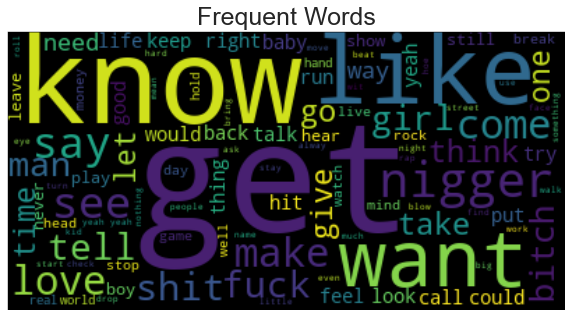

In [40]:
#generating wordcloud
cloud = WordCloud(max_words=100, background_color="black", stopwords=stops) 
cloud_string = ' '.join(song for song in lyrics_lda) #need to form a string of all words for wordcloud
cloud.generate(cloud_string) 

#plotting
fig, ax = plt.subplots(figsize=(10, 10)) 
ax.imshow(cloud, interpolation='bilinear') 
ax.set_title("Frequent Words",fontsize=25)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

Analysing most frequent bigrams. As expected, the most common bigrams are full of stop words. The most common word in these bigrams is 'you', suggesting that the subject of the many songs is the second person.

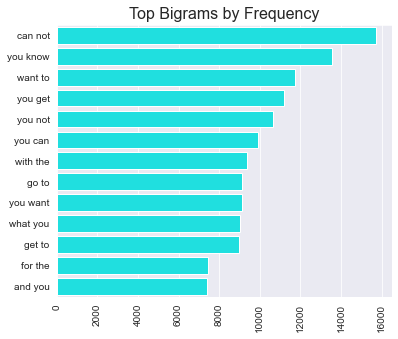

In [41]:
#NLTK frequency distirbution requires list of all words
dataset_corpus_final = [token for sublist in lyrics_final for token in sublist]

#create frequency distribution
bigram = bigrams(dataset_corpus_final)
bigram_fd = FreqDist(bigram).most_common(15)
bigram_fd = [((x + ' ' + y), f) for ((x, y), f) in bigram_fd] #joining bigrams into one string

        
#first convert bigram distribution to dictionary and then to pandas series
bigram_dict = {n:(f) for n,f in bigram_fd if 'UNK' not in n} #remove 'UNK' if it appears in top bigrams
bigram_srs = pd.Series(bigram_dict)

#plotting
fig, ax = plt.subplots(figsize=(6,5))
bar_plot = sns.barplot(x=bigram_srs.values, y=bigram_srs.index, ax=ax, color = 'cyan')
plt.title('Top Bigrams by Frequency', fontsize = 16)
plt.xticks(rotation=90);


### IV.IV Songs by Topic

In this subsection I analyse the distribution of the four identified topics. First, I combine the relevant results into one dataframe. I also do some data grouping which will be used for the graphical analysis below.

In [42]:
#creating dataframe of required info
df_results = data_lda[['Title','URL','Artist','Decade','Length_Seconds','Lyric_Length','Distinct_Words','Sentiment_Score']].copy()

#adding topic labels to songs
df_results['Dominant_Topic_Label'] = dominant_topic_label
df_results['Dominant_Topic_Prob'] = dominant_topic_prob

#calculating counts and means data for charts
n_songs_topic = df_results.groupby(['Dominant_Topic_Label']).count()['Title'] #count by topic
means_topic = df_results.groupby(['Dominant_Topic_Label']).mean()[['Sentiment_Score', 'Lyric_Length', 'Distinct_Words', 'Length_Seconds']] #means by topic

#calculating percentages of topic in decade
decade_topics_sr = df_results.groupby(['Decade','Dominant_Topic_Label']).count()['Title'] #extract series
decade_topics_sr = decade_topics_sr.groupby(level=0).apply(lambda x: 100*x/x.sum()) #calculating percentages by level 0 (sum of songs in decade)
decade_topics = decade_topics_sr.reset_index() #convert index to numeric (allows us to use decade and topic label in chart)

Here I provide a descriptive graphical analysis of the distribution of topics.

There are a number of interesting observations that can be made from this graphical analysis. With regard to topic frequency, we can see that the most popular topics over the years have been the Emotional and Philisophical topics. Indeed, despite the bad rep that rap music gets for being violent and expletive, the Issues/Crime topic only ranks third out of four topics in song frequency. The Party topic was by far the least common topic in the dataset, having less than half of the observations of the most common topics. 

The time dyanmics, however, show that the nature of the genre is changing. The Philosophical topic was very popular in the period before 1990 - this is the period when the rap genre actually started taking form. This topic could be capturing the spiritual or religious focus that some rap artists are known for. The Party topic was also much more popular during this period, probably reflecting the origins of rap and hip hop music in party and disco atmospheres. As time passed and the genre developed, the Philosophical and Party topics appear to have diminished in popularity. One the other hand, the Emotional topic - always a popular topic in all genres - maintained and even slightly increased its share of rap songs. The Issues/Crime topic was the biggest upward mover over the past decades - from less than 5% of observations for the pre-1990 period, it comprised over 30% of songs in the 2010s.

When analysing song length there is a clear distinction between the Emotional topic and the other topics. Emotional songs are shorter in lyric length, and also contain less distinct words. This might be explained by the fact that Emotional songs may include more choruses, meaning a higher repetition of words. On the other hand, songs in the Issues/Crime topic have the the longest lyrics on average and, along with the Philosophical topic, the most distinct words. Interestingly, despite these differences in lyric length, average song duration is very similar accross all topics. This could mean that the speed of rap is much faster in the Issues/Crime topic, comprising more lyrics per second. On the other hand, the Emotional topic is much slower, as would be expected.

The greatest distinction between topics is in their sentiment scores. The Emotional and Party topics score an average positive sentiment. This is expected, given that the common words in these topics are based around positive themes such as love, fun, and dance. Meanwhile, the Issues/Crime topic has a negative score, again expected due to the high number of expletive or crime/violence-related words. The Philosophical topic scored a neutral score on average. 

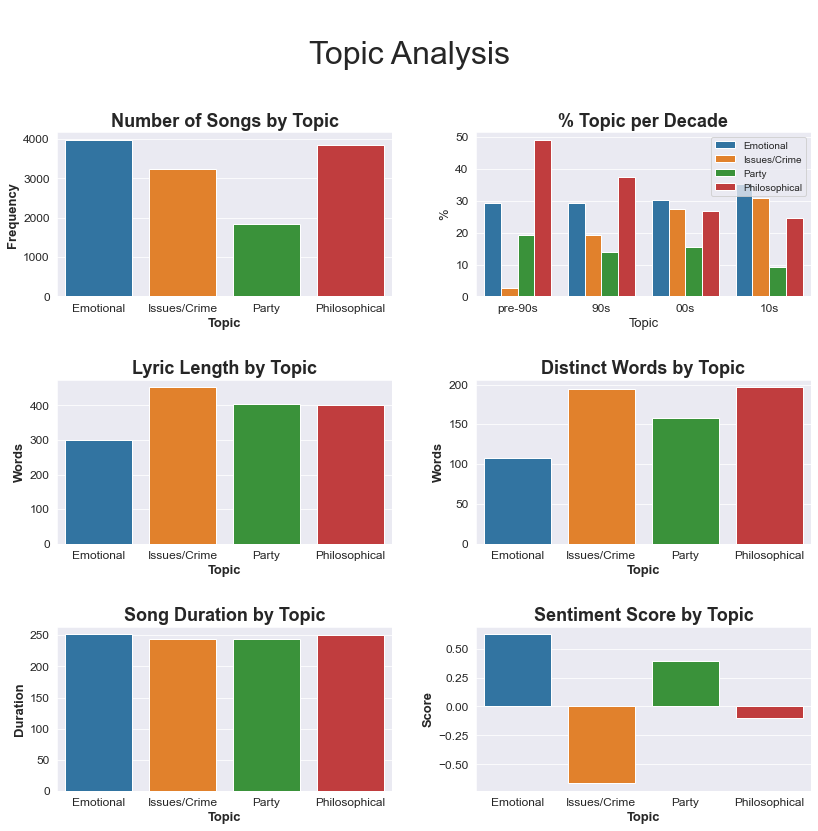

In [47]:
#plotting

#figure variables
title_font_size = 18
label_font_size = 13
tick_font_size = 12

#initiating figure
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
fig.suptitle('\nTopic Analysis', fontsize=32)

#number of songs by topic
sns.barplot(ax = ax[0,0], x=n_songs_topic.index, y=n_songs_topic)
ax[0,0].set_title("Number of Songs by Topic",fontsize=title_font_size, fontweight='bold')
ax[0,0].set_xlabel("Topic",fontsize=label_font_size, fontweight='bold')
ax[0,0].set_ylabel("Frequency",fontsize=label_font_size, fontweight='bold')
ax[0,0].tick_params(labelsize=tick_font_size)

#topics by decade
order = ['pre-90s', '90s', '00s', '10s']
sns.barplot(ax = ax[0,1], x="Decade", y='Title', data=decade_topics, hue = "Dominant_Topic_Label", order = order)
ax[0,1].set_title("% Topic per Decade", fontsize=title_font_size, fontweight='bold')
ax[0,1].set_xlabel("Topic",fontsize=label_font_size)
ax[0,1].set_ylabel("%",fontsize=label_font_size)
ax[0,1].tick_params(labelsize=tick_font_size)
ax[0,1].legend(loc = 'upper right')

#mean lyric length
sns.barplot(ax = ax[1,0], x=means_topic.index, y=means_topic['Lyric_Length'])
ax[1,0].set_title("Lyric Length by Topic", fontsize=title_font_size, fontweight='bold')
ax[1,0].axes.set_xlabel("Topic",fontsize=label_font_size, fontweight='bold')
ax[1,0].set_ylabel("Words",fontsize=label_font_size, fontweight='bold')
ax[1,0].tick_params(labelsize=tick_font_size)

#mean distinct words 
sns.barplot(ax = ax[1,1], x=means_topic.index, y=means_topic['Distinct_Words'])
ax[1,1].set_title("Distinct Words by Topic", fontsize=title_font_size, fontweight='bold')
ax[1,1].axes.set_xlabel("Topic",fontsize=label_font_size, fontweight='bold')
ax[1,1].set_ylabel("Words",fontsize=label_font_size, fontweight='bold')
ax[1,1].tick_params(labelsize=tick_font_size)

#mean duration
sns.barplot(ax = ax[2,0], x=means_topic.index, y=means_topic['Length_Seconds'])
ax[2,0].set_title("Song Duration by Topic", fontsize=title_font_size, fontweight='bold')
ax[2,0].axes.set_xlabel("Topic",fontsize=label_font_size, fontweight='bold')
ax[2,0].set_ylabel("Duration",fontsize=label_font_size, fontweight='bold')
ax[2,0].tick_params(labelsize=tick_font_size)

#mean sentiment 
sns.barplot(ax = ax[2,1], x=means_topic.index, y=means_topic['Sentiment_Score'])
ax[2,1].set_title("Sentiment Score by Topic", fontsize=title_font_size, fontweight='bold')
ax[2,1].axes.set_xlabel("Topic",fontsize=label_font_size, fontweight='bold')
ax[2,1].set_ylabel("Score",fontsize=label_font_size, fontweight='bold')
ax[2,1].tick_params(labelsize=tick_font_size)


fig.tight_layout(pad=3.0); #pad allows for increased spacing between plots

# #code to plot single figure
# order = ['pre-90s', '90s', '00s', '10s']
# fig_decade_topics = sns.barplot(x="Decade", y='Title', data=df_decade_topics, hue = "Dominant_Topic_Label", order = order)
# fig_decade_topics.set_title("% Topic per Decade", fontsize=18)
# fig_decade_topics.axes.set_xlabel("Topic",fontsize=14)
# fig_decade_topics.axes.set_ylabel("%",fontsize=14)
# fig_decade_topics.axes.tick_params(labelsize=12)
# fig_decade_topics.axes.legend(loc = 'upper right');

Here I analyse top artists per topic. 

For those with good knowledge of rap music and artists, the results are as expected. The interesting observation is Mariah Carey placing first in the Emotional category. Despite not being a rapper herself, she has done numerous collaborations with famous rap artists, contributing to her positioning in this list.

Artists normally have their own style, meaning that artists featuring prominently in one topic do not feature in the top ranks of other topics. Notable exceptions include Jay-Z, who has several songs in both the Philosophical and Issues/Crime topics, and R. Kelly, in the Emotional and Party topics.

In [48]:
def top_artists_by_topic(topic_label, df_results, n):
    '''
    DESCRIPTION:
    Get top n artists per topic
    PARAMETERS:
    topic_label is string topic label 
    df_results is dataframe of songs
    n is number of top artists per topic to output
    OUTPUT
    Printed output of top artists for topic
    '''
    df_topic = df_results[df_results['Dominant_Topic_Label']==topic_label].copy() #filtering by topic label

    #extracting topic artists and converting strings to lists
    artists_topic = [ast.literal_eval(lst) for lst in df_topic['Artist']] 
    artists_topic = [artist.lower() for sublist in artists_topic for artist in sublist] #list of all topic artists
    
    #counting artists in topic
    artists_topic_count = {}
    for artist in set(artists_topic):
        artists_topic_count[artist.title()] = artists_topic.count(artist) #title() re-capitalises artist names

    top_topic_artists = sorted(artists_topic_count, key=artists_topic_count.get, reverse=True)[:n] #get top five artists

    print(f'\nTop Artists for {topic_label} Topic:')
    rank = 1
    for artist in top_topic_artists:
        print(f'{rank}.  {artist} - {artists_topic_count[artist]} songs')
        rank += 1
        
for topic_label in topic_labels:
    top_artists_by_topic(topic_label, df_results, n=5)


Top Artists for Emotional Topic:
1.  Mariah Carey - 60 songs
2.  R. Kelly - 44 songs
3.  Mary J. Blige - 44 songs
4.  Drake - 42 songs
5.  Usher - 41 songs

Top Artists for Philosophical Topic:
1.  Nas - 86 songs
2.  Eminem - 82 songs
3.  Jay-Z - 70 songs
4.  Ghostface Killah - 46 songs
5.  Kanye West - 45 songs

Top Artists for Issues/Crime Topic:
1.  Snoop Dogg - 121 songs
2.  Lil Wayne - 111 songs
3.  Jay-Z - 87 songs
4.  Rick Ross - 74 songs
5.  T.I. - 62 songs

Top Artists for Party Topic:
1.  Missy Elliott - 36 songs
2.  R. Kelly - 32 songs
3.  Ll Cool J - 27 songs
4.  Ludacris - 25 songs
5.  Lil Jon - 25 songs


### IV.V Model Evaluation

The best way of evaluating the results is to use the graphical analysis provided by pyLDAvis above. The size of the buddles indicates that all four topics had a high frequency of songs. Furthermore, there is no overlap between the bubbles, meaning that the model was generally quite sure about the topic clustering. We can also see that all sections of the 2D space have one bubble, meaning that the topics identified capture the spread of the song topic variability.

Another measure that could be used for evaluation is perplexity, also shown above. However, this is not really useful on its own - it would be more useful in comparing this model with another.

## V. Conclusion

The aim of this project was to provide a detailed analysis of lyrics from rap and hip hop songs and use an unsupervised model to identify the latent topics hidden in the lyrics. 

A dataset of thousands of rap and hip hop song lyrics was scraped from Lyrics.com. Due to the large amount of dialect and other word contractions, the lyrics had to undergo a thorough cleaning process before being analysed. The cleaned dataset contained just under 13,000 song lyrics.

Using a Latent Dirichtet Allocation (LDA), four distinct topics were uncovered in the dataset. These were identified as Emotional, Philosophical, Party, and Issues/Crime. Each topic has its own unique characteristics, ranging from artists to lyric length, senitment score, and lyric speed. The results also threw some light on the changing topic distribution of the rap genre over the past four decades.

Before concluding, I would also like to point out some limitations and ethical considerations of this study. The study was conducted using a publicly available dataset of song lyrics from publicly available songs. The intent is to throw light on the lyrical variety of a greatly misunderstood genre. Despite rap's bad reputation of promoting violence, this project showed that this genre has a  wide topic diversity, and the content and message of each song needs to be judged as a whole to be appreciated. 

The model chosen for this project was an LDA, but there are other models that could be used for unsupervised topic modelling, all of which may give different results. The results of the LDA can be particularly sensitive to the model hyperparameters, such as excluded features or the number of topics. While care was taken in choosing the appropriate hyperparameters, these are ultimately based on subjective judgement. Another point to mention is that the LDA is based on a bag of words representation of the text - hence, the model only looks for the presence of individual words in a song, not at the context of these words.

All songs analysed are in the public domain, and there is no guarantee that the scraped lyrics are 100% accurate. Furthermore, although I attempted to manually clean a large chunk of the dataset, I cannot gaurantee that all non-dictionary tokens were removed from the dataset. An interesting further analysis of this project would be to test the impact of this rigorous cleaning on the final results - would the topic groupings have remained similar if only basic cleaning was performed? 

Any errors and conclusions presented in this study are the author's own.

## References

<b>BOOKS & PAPERS</b>
<ul>
    <li>Bird et. al (2009). Natural Language Processing with Python. O'Reilly Media, Inc., first edition. </li>
    <li>Jurafsky & Martin (2020). Speech and Language Processing. Third edition draft. </li>
    <li>McKinney, W. Python for Data Analysis (2017). O'Reilly Media, Inc., second edition. </li>
    <li>Sievert, C. & Shirley, K. (2014). LDAvis: A method for visualizing and interpreting topics. Available at: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf</li>
</ul>

<b>UNIVERSITY OF LONDON</b>
<ul>
    <li>DSM020 Module - Data Programming in Python Module (McGrath, S.)</li>
    <li>DSM020 Coursework I - <i>Where words fail, music speaks</i></li>
    <li>DSM140 Module - Natural Language Processing (Russell-Rose, T.)</li>
</ul>

<b>WEBPAGES CONSULTED</b>
<ul>
    <li>https://en.wikipedia.org/wiki/Rapping</li>
    <li>https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools</li>
    <li>https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2</li>
    <li>https://tim-denzler.medium.com/whats-in-a-song-using-lda-to-find-topics-in-over-120-000-songs-53785767b692</li>
    <li>https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0</li>
    <li>https://blog.mlreview.com/topic-modeling-with-scikit-learn-e80d33668730</li>
    <li>https://towardsdatascience.com/improving-the-interpretation-of-topic-models-87fd2ee3847d</li>
    <li>https://yanlinc.medium.com/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6</li>
    <li>https://nicharuc.github.io/topic_modeling/</li>
    <li>https://www.objectorientedsubject.net/2018/08/experiments-on-topic-modeling-pyldavis//</li>
</ul>